In [1]:
%load_ext autoreload
%autoreload 2

# Import all required library
import os
import time
import math

import numpy as np
import pandas as pd

import tqdm

import warnings
warnings.filterwarnings("ignore")

import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AdamW, 
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
    Trainer, 
    TrainingArguments,
    AutoModelForCausalLM,
    set_seed
)

from peft import (
    LoraConfig, 
    get_peft_model, 
    TaskType,
    PeftModel,
    AdaLoraConfig,
    AdaLoraModel,
    VeraConfig,
)

import datasets 

KeyboardInterrupt: 

In [ ]:
seed = 42
#reproducibility
def _seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    set_seed(seed)

_seed(seed)

In [ ]:
# Define a function that can print the trainable parameters 
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params} \nall model parameters: {all_model_params}{"\n"}percentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [ ]:
# full_data = pd.read_csv("7-prompts.csv")
# print(f"We have {len(full_data)} samples") # Number of data we have

# print(full_data.sample(5,random_state=19))

# full_data = full_data.head(1000) # Subset the data for testing the code

In [ ]:
# from sklearn.model_selection import train_test_split

# # Split it when augmented data is ready
# X_train, X_val, y_train, y_val = train_test_split(full_data["text"],
#                                                   full_data["label"],
#                                                   test_size=0.3,
#                                                   stratify=full_data["label"],
#                                                   random_state=42)
# print(f"We have {len(X_train)} training samples")
# print(f"We have {len(X_val)} validation samples")
# print("----------------------------")
# count = full_data["label"].value_counts()
# print(f"Number of Essays written by Human: {count[0]}")
# print(f"Number of Essays generated by LLM: {count[1]}")

# X_train.reset_index(drop = True, inplace = True)
# y_train.reset_index(drop = True, inplace = True)
# X_val.reset_index(drop = True, inplace = True)
# y_val.reset_index(drop = True, inplace = True)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load DistilBERT model and tokenizer (uncased)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", return_dict=True, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Print the number of trainable parameters
print(print_number_of_trainable_model_parameters(model))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model parameters: 66955010 
all model parameters: 66955010
percentage of trainable model parameters: 100.00%


In [ ]:
def print_trainable_layers(model):
    """
    Print names of all trainable layers in a PyTorch model.
    
    Args:
        model: PyTorch model (nn.Module)
    """
    trainable_layers = [
        name for name, param in model.named_parameters()
        if param.requires_grad
    ]
    
    print("Trainable layers:")
    for layer in trainable_layers:
        print(f"  - {layer}")

print_trainable_layers(model)

Trainable layers:
  - distilbert.embeddings.word_embeddings.weight
  - distilbert.embeddings.position_embeddings.weight
  - distilbert.embeddings.LayerNorm.weight
  - distilbert.embeddings.LayerNorm.bias
  - distilbert.transformer.layer.0.attention.q_lin.weight
  - distilbert.transformer.layer.0.attention.q_lin.bias
  - distilbert.transformer.layer.0.attention.k_lin.weight
  - distilbert.transformer.layer.0.attention.k_lin.bias
  - distilbert.transformer.layer.0.attention.v_lin.weight
  - distilbert.transformer.layer.0.attention.v_lin.bias
  - distilbert.transformer.layer.0.attention.out_lin.weight
  - distilbert.transformer.layer.0.attention.out_lin.bias
  - distilbert.transformer.layer.0.sa_layer_norm.weight
  - distilbert.transformer.layer.0.sa_layer_norm.bias
  - distilbert.transformer.layer.0.ffn.lin1.weight
  - distilbert.transformer.layer.0.ffn.lin1.bias
  - distilbert.transformer.layer.0.ffn.lin2.weight
  - distilbert.transformer.layer.0.ffn.lin2.bias
  - distilbert.transformer

In [ ]:
# Define the LoRA Configuration
lora_config = LoraConfig(
    r=8, # Rank Number
    lora_alpha=32, # Alpha (Scaling Factor)
    lora_dropout=0.05, # Dropout Prob for Lora
    target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
    bias='none',
    # use_dora=True,
    # init_lora_weights='pissa',
    task_type=TaskType.SEQ_CLS, # Seqence to Classification Task

)
# Define the LoRA Configuration
# lora_config = AdaLoraConfig(
#     init_r=12, # Rank Number
    
#     lora_alpha=32, # Alpha (Scaling Factor)
#     lora_dropout=0.05, # Dropout Prob for Lora
#     target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
#     bias='none',
#     # init_lora_weights='pissa',
#     task_type=TaskType.SEQ_CLS, # Seqence to Classification Task

# )
# lora_config = AdaLoraConfig(
#     task_type=TaskType.SEQ_CLS,
#     r=8,  # Initial rank
#     lora_alpha=32,
#     target_r=4,  # Target rank after pruning
#     init_r=12,  # Initial rank before pruning
#     beta1=0.85,  # Hyperparameter for updating importance score
#     beta2=0.85,  # Hyperparameter for updating gradient scale
#     tinit=200,  # Warmup steps
#     tfinal=1000,  # When to stop rank allocation
#     deltaT=10,  # Time internal for rank allocation
#     lora_dropout=0.1,
#     inference_mode=False,
#     bias="none",
#     modules_to_save=None,
#     # Target modules for DistilBERT
#     target_modules=["q_lin", "k_lin", "v_lin",]
# )

# lora_config = VeraConfig(r=256,target_modules=["q_lin", "k_lin","v_lin"], # Which layer to apply LoRA, usually only apply on MultiHead Attention Layer
#     bias='none',
#     # init_lora_weights='pissa',
#     task_type=TaskType.SEQ_CLS, # Seqence to Classification Task
# )

In [ ]:
# Get our LoRA-enabled model
peft_model = get_peft_model(model, 
                            lora_config,)
                            

# Reduced trainble parameters
print(print_number_of_trainable_model_parameters(peft_model))
print_trainable_layers(peft_model)

NameError: name 'lora_config' is not defined

In [ ]:
for name,a in peft_model.named_parameters():
    if a.requires_grad:
        print(name)

# peft_model

NameError: name 'peft_model' is not defined

In [ ]:
def find_r(d,m,c):
    return (d*m)/(c*d + c*m)


for name,key in peft_model.named_parameters():
    if 'base_layer' in name:
        print(name, " ", key.shape)
        

base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.weight   torch.Size([768, 768])
base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.bias   torch.Size([768])
base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.weight   torch.Size([768, 768])
base_model.model.distilbert.transformer.layer.0.attention.k_lin.base_layer.bias   torch.Size([768])
base_model.model.distilbert.transformer.layer.0.attention.v_lin.base_layer.weight   torch.Size([768, 768])
base_model.model.distilbert.transformer.layer.0.attention.v_lin.base_layer.bias   torch.Size([768])
base_model.model.distilbert.transformer.layer.1.attention.q_lin.base_layer.weight   torch.Size([768, 768])
base_model.model.distilbert.transformer.layer.1.attention.q_lin.base_layer.bias   torch.Size([768])
base_model.model.distilbert.transformer.layer.1.attention.k_lin.base_layer.weight   torch.Size([768, 768])
base_model.model.distilbert.transformer.layer.1.attention.k_lin.b

In [ ]:
# # Tokenize function
# def tokenize_func(data):
#     return tokenizer(
#             data['texts'],
#             max_length=512,
#             padding='max_length',
#             return_attention_mask=True,
#             truncation=True
#         )

In [ ]:
# # Tokenize the Training Data
# train_dataset = datasets.Dataset.from_pandas(pd.DataFrame({"texts":X_train,"labels":y_train}))
# train_dataset = train_dataset.map(
#     tokenize_func,
#     batched=True,
#     remove_columns=["texts"]
# )
# train_dataset

In [ ]:
# # Tokenize the Validation Data
# val_dataset = datasets.Dataset.from_pandas(pd.DataFrame({"texts":X_val,"labels":y_val}))
# val_dataset = val_dataset.map(
#     tokenize_func,
#     batched=True,
#     remove_columns=["texts"]
# )

# val_dataset

In [ ]:
from datasets import load_dataset
def preprocess_glue(task_name='qnli'):
    """
    Preprocesses GLUE tasks for fine-tuning DistilBERT with HuggingFace's Trainer class.
    
    Args:
        task_name (str): Name of the GLUE task ('mnli', 'sst2', 'qqp', 'qnli')
        
    Returns:
        tuple: (train_dataset, eval_dataset) preprocessed datasets ready for Trainer
    """
    
    # Check if cached dataset exists
    folder_path = f"/home/marco.garofalo/flower-for-tests/datasets/{task_name}"
    if os.path.isdir(folder_path):
        from datasets import load_from_disk
        dataset_dict = load_from_disk(folder_path)
    else:
        dataset_dict = load_dataset("glue", task_name)
        # Save dataset for future use
        os.makedirs(folder_path, exist_ok=True)
        dataset_dict.save_to_disk(folder_path)

    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    
    # Define tokenization function based on task
    def tokenize_func(examples):
        if task_name == "mnli":
            return tokenizer(
                examples["premise"],
                examples["hypothesis"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "sst2":
            return tokenizer(
                examples["sentence"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "qqp":
            return tokenizer(
                examples["question1"],
                examples["question2"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
        elif task_name == "qnli":
            return tokenizer(
                examples["question"],
                examples["sentence"],
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
    
    # Get columns to remove based on task
    columns_to_remove = {
        "mnli": ["premise", "hypothesis", "idx"],
        "sst2": ["sentence", "idx"],
        "qqp": ["question1", "question2", "idx"],
        "qnli": ["question", "sentence", "idx"]
    }
    
    # Tokenize datasets
    tokenized_datasets = dataset_dict.map(
        tokenize_func,
        batched=True,
        remove_columns=columns_to_remove[task_name]
    )
    
    # Convert to PyTorch tensors and rename columns for Trainer compatibility
    def convert_to_features(example_batch):
        features = {
            'input_ids': example_batch['input_ids'],
            'attention_mask': example_batch['attention_mask'],
            'labels': example_batch['label']
        }
        return features

    tokenized_datasets = tokenized_datasets.map(
        convert_to_features,
        batched=True
    )
    
    # Set format for pytorch
    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    
    # Get the appropriate validation set
    eval_key = 'validation_matched' if task_name == 'mnli' else 'validation'
    
    return tokenized_datasets['train'], tokenized_datasets[eval_key]

train_dataset, val_dataset = preprocess_glue('qnli')

In [ ]:
from transformers import TrainerCallback
def analyze_lora_impact(model, layer_idx=0):
    # Get the attention components for a specific layer
    layer = model.base_model.model.distilbert.transformer.layer[layer_idx].attention
    
    # Analyze Q, K, V matrices
    for name, component in [('Query', layer.q_lin), ('Key', layer.k_lin), ('Value', layer.v_lin)]:
        # Get base weights
        base_weight = component.base_layer.weight
        
        # Get LoRA weights
        lora_A = component.lora_A['default'].weight
        lora_B = component.lora_B['default'].weight
        
        # Calculate LoRA contribution
        lora_contribution = (lora_B @ lora_A).detach()
        
        # Calculate metrics
        base_norm = torch.norm(base_weight).item()
        lora_norm = torch.norm(lora_contribution).item()
        relative_impact = (lora_norm / base_norm) * 100
        
        print(f"\n{name} Matrix Analysis:")
        print(f"Base weight norm: {base_norm:.4f}")
        print(f"LoRA contribution norm: {lora_norm:.4f}")
        print(f"Relative LoRA impact: {relative_impact:.2f}%")
        
        # Optional: Calculate max absolute changes
        max_change = torch.max(torch.abs(lora_contribution)).item()
        print(f"Max absolute LoRA change: {max_change:.4f}")

class LoRATrackingCallback(TrainerCallback):
    def __init__(self, eval_steps=100):
        self.eval_steps = eval_steps
        self.history = []
    
    def on_step_end(self, args, state, control, model, **kwargs):
        with torch.no_grad():
            if state.global_step % self.eval_steps == 0:
                metrics = {}
                for layer_idx in range(6):
                    layer = model.base_model.model.distilbert.transformer.layer[layer_idx].attention
                    for name, component in [('q', layer.q_lin), ('k', layer.k_lin), ('v', layer.v_lin)]:
                        lora_A = component.lora_A['default'].weight
                        lora_B = component.lora_B['default'].weight
                        if hasattr(component,'lora_S'):
                            lora_S = component.lora_S['default']

                            lora_norm = torch.norm((lora_B @ (torch.diag(lora_S.direction)*lora_S.weight) @ lora_A).detach()).item()
                        else:
                            lora_norm = torch.norm((lora_B @ lora_A).detach()).item()

                        metrics[f'layer_{layer_idx}_{name}_lora_norm'] = lora_norm
                
                self.history.append({
                    'step': state.global_step,
                    **metrics
                })

# Use in training
callback = LoRATrackingCallback(eval_steps=10)

In [ ]:
from transformers import EarlyStoppingCallback, TrainerCallback

# Define Early Stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.0,  # Any decline in metric will count
)
# Define Eval Metric
def metrics(eval_prediction):
    logits, labels = eval_prediction
    pred = np.argmax(logits, axis=1)
    
    # Calculate AUC
    auc_score = roc_auc_score(labels, pred)
    
    # Calculate Accuracy
    accuracy = (pred == labels).mean()
    
    return {
        "Val-AUC": auc_score,
        "Val-Accuracy": accuracy
    }

train_batch_size = 32
eval_batch_size = 32

# Define training Args
peft_training_args = TrainingArguments(
    output_dir='./sst2-result-distilbert-slora-only-mag',
    logging_dir='./sst2-logs-distilbert-slora-only-mag',
#     auto_find_batch_size=True,
    learning_rate=1e-4,
    per_device_train_batch_size=train_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
    per_device_eval_batch_size=eval_batch_size, # You can adjust this value base on your available GPU, You may encounter "out of memory" error if this value is too lartge
    num_train_epochs=2,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=10,
    weight_decay=0.01,
    seed=42,
    fp16=True, # Only use with GPU
    report_to='none',
    load_best_model_at_end=True,
    metric_for_best_model="Val-Accuracy"
)   

# Define Optimzer
optimizer = AdamW(model.parameters(), 
                  lr=1e-4,
                  no_deprecation_warning=True)

# Define Scheduler
n_epochs = peft_training_args.num_train_epochs
total_steps = n_epochs * math.ceil(len(train_dataset) / train_batch_size / 2)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)

# Data Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer, 
    padding="longest"
)

# Define Trainer
peft_trainer = Trainer(
    model=model,
    args=peft_training_args,
    train_dataset=train_dataset, # Training Data
    eval_dataset=val_dataset, # Evaluation Data
    tokenizer=tokenizer,
    compute_metrics=metrics,
    optimizers=(optimizer,lr_scheduler),
    data_collator=collator,
    callbacks=[],  # Add early stopping callback

)

print(f"Total Steps: {total_steps}")

# Path to save the fine-tuned model
# torch.save(model.state_dict(), "fft_model.pth")

# Train the model
peft_trainer.train()

# peft_trainer.model.save_pretrained(peft_model_path) # Save the fine-tuned model
# tokenizer.save_pretrained(peft_model_path) # Save the tokenizer

Total Steps: 3274


Step,Training Loss,Validation Loss,Val-auc,Val-accuracy
10,0.695100,0.692962,0.511727,0.516566
20,0.698100,0.693700,0.500189,0.505583
30,0.688700,0.688672,0.546583,0.543840
40,0.692300,0.685577,0.571196,0.573128
50,0.688700,0.682541,0.557528,0.553908
60,0.681200,0.674817,0.607233,0.605162
70,0.669100,0.664203,0.590732,0.587223
80,0.666100,0.640961,0.671167,0.671792
90,0.637900,0.614853,0.686007,0.685338
100,0.603100,0.584909,0.711318,0.711514


KeyboardInterrupt: 

In [ ]:
import numpy as np
from collections import defaultdict

def group_lora_parameters(client_parameters, keys):
    """
    Groups LoRA parameters by layer and type across multiple clients.
    
    Args:
        client_parameters: List of lists containing parameters for each client
        keys: List of tuples containing (index, parameter_name)
    
    Returns:
        dict: Nested dictionary organizing parameters by layer and LoRA type
    """
    # Create a nested defaultdict for automatic dictionary creation
    grouped_params = defaultdict(lambda: defaultdict(list))
    
    # For each client's parameters
    for client_params in client_parameters:
        # Process each parameter set
        for idx, key_tuple in enumerate(keys):
            param_idx, param_name = key_tuple
            
            # Extract base name (remove .lora_A or .lora_B)
            if 'lora_' in param_name:
                base_name = param_name.rsplit('.lora_', 1)[0]
                lora_type = 'lora_' + param_name.split('lora_')[1]
                
                # Add parameter to the appropriate group
                grouped_params[base_name][lora_type].append(client_params[param_idx])
    
    # Convert defaultdict to regular dict for return
    return {
        base_name: dict(lora_types)
        for base_name, lora_types in grouped_params.items()
    }

# Example usage:
if __name__ == "__main__":
    # Sample data
    client_parameters = [
        [np.random.rand(10, 5) if i % 2 == 0 else np.random.rand(5,10) for i in range(10)],  # Client 1
        [np.random.rand(10, 5) if i % 2 == 0 else np.random.rand(5,10) for i in range(10)],  # Client 2
        [np.random.rand(10, 5) if i % 2 == 0 else np.random.rand(5,10) for i in range(10)],  # Client 3

    ]

    keys = [
        (0, "distilbert.transformer.layer.0.attention.q_lin.weight.lora_A"),
        # (2, "distilbert.transformer.layer.0.attention.q_lin.weight.lora_S"),
        (1, "distilbert.transformer.layer.0.attention.q_lin.weight.lora_B"),
        (2, "distilbert.transformer.layer.0.attention.k_lin.weight.lora_A"),
        # (5, "distilbert.transformer.layer.0.attention.k_lin.weight.lora_S"),
        (3, "distilbert.transformer.layer.0.attention.k_lin.weight.lora_B"),
    ]

    # Group the parameters
    grouped = group_lora_parameters(client_parameters, keys)

    # Print structure (without the actual arrays for readability)
    for base_name, lora_types in grouped.items():
        print(f"\nBase name: {base_name}")
        for lora_type, params in lora_types.items():
            print(f"  {lora_type}: {len(params)} client parameters")

print(grouped)


Base name: distilbert.transformer.layer.0.attention.q_lin.weight
  lora_A: 3 client parameters
  lora_B: 3 client parameters

Base name: distilbert.transformer.layer.0.attention.k_lin.weight
  lora_A: 3 client parameters
  lora_B: 3 client parameters
{'distilbert.transformer.layer.0.attention.q_lin.weight': {'lora_A': [array([[0.21195909, 0.53203469, 0.17655419, 0.63499507, 0.29165319],
       [0.79153262, 0.80811035, 0.46378746, 0.18081064, 0.64677496],
       [0.99278702, 0.6225909 , 0.03577469, 0.01729398, 0.32036197],
       [0.19578381, 0.81305121, 0.84480567, 0.25861877, 0.32564478],
       [0.23624697, 0.90838255, 0.50264933, 0.65613704, 0.41548209],
       [0.63101419, 0.38585538, 0.33967844, 0.63448007, 0.59106208],
       [0.29352795, 0.14934845, 0.36857669, 0.41519764, 0.62868433],
       [0.91452876, 0.0361848 , 0.24366101, 0.19371594, 0.50229441],
       [0.42970081, 0.72903762, 0.24241591, 0.59449837, 0.88385726],
       [0.91067774, 0.9587846 , 0.77326115, 0.90598791, 0

In [ ]:
def compute_lora_cross_residuals(grouped_parameters):
    """
    Computes residual matrices for each layer from grouped LoRA parameters.
    The residual for each layer is computed as sum(lora_B_i @ lora_A_j) for all i!=j.
    
    Args:
        grouped_parameters: Dictionary of grouped LoRA parameters with structure:
            {
                "layer_name": {
                    "lora_A": [client1_A, client2_A, ...],
                    "lora_B": [client1_B, client2_B, ...]
                }
            }
    
    Returns:
        dict: Dictionary mapping layer names to their residual matrices
    """
    residuals = {}
    
    for layer_name, lora_params in grouped_parameters.items():
        # Get lora A and B parameters for all clients
        lora_A_params = lora_params['lora_A']
        lora_B_params = lora_params['lora_B']
        num_clients = len(lora_A_params)
        
        # Initialize residual matrix for this layer
        first_B, first_A = lora_B_params[0], lora_A_params[0]
        residual = np.zeros((first_B.shape[0], first_A.shape[1]))
        
        # Sum up the cross-residuals from all clients (i != j)
        for i in range(num_clients):
            for j in range(num_clients):
                if i != j:  # Only compute cross terms
                    residual += lora_B_params[i] @ lora_A_params[j]
            
        residuals[layer_name] = residual
    
    return residuals

compute_lora_cross_residuals(grouped)

{'distilbert.transformer.layer.0.attention.q_lin.weight': array([[ 7.68151668, 12.50576674, 12.44454998, 14.34105631, 12.44907873],
        [ 9.50668995, 13.6357766 , 15.18095117, 15.24629088, 16.15830288],
        [ 8.56604808, 12.87460244, 13.05438959, 14.31172368, 13.65657473],
        [12.24278206, 16.70601097, 17.13734538, 17.39792304, 16.69871775],
        [14.6208131 , 18.61052304, 19.72180788, 19.45935801, 18.65051607]]),
 'distilbert.transformer.layer.0.attention.k_lin.weight': array([[16.16891516, 12.91828372, 16.45526732, 14.06095568, 14.45734314],
        [16.76178806, 13.91653155, 16.38687633, 14.9758059 , 15.93762139],
        [20.28526034, 16.13850539, 21.08739325, 16.9055011 , 18.68266404],
        [16.65527956, 13.62397258, 17.90958853, 12.47892851, 14.12006567],
        [17.57248633, 15.52144644, 17.11457044, 15.25204899, 16.63392159]])}

In [ ]:
print(client_parameters[0])

[array([[0.12742078, 0.54556254, 0.85795746, 0.67806038, 0.29608209],
       [0.56161616, 0.71485597, 0.72810449, 0.66653846, 0.87081042],
       [0.87010546, 0.57893656, 0.42985637, 0.6415703 , 0.818212  ],
       [0.0056521 , 0.99199701, 0.18289377, 0.47024899, 0.87202973],
       [0.2250404 , 0.47679522, 0.13258218, 0.39507633, 0.17713545],
       [0.36362775, 0.37346422, 0.99317079, 0.99481303, 0.11478628],
       [0.72596878, 0.05174548, 0.03019202, 0.10533389, 0.96548566],
       [0.94086355, 0.19392782, 0.16167234, 0.24053509, 0.51554699],
       [0.56970463, 0.22159343, 0.75662279, 0.30955317, 0.92213133],
       [0.65672271, 0.43635119, 0.789912  , 0.81791463, 0.29048161]]), array([[0.33971454, 0.93595515, 0.16474104, 0.04215042, 0.45405532],
       [0.8012099 , 0.77166811, 0.91953063, 0.53320066, 0.10006467],
       [0.58868897, 0.77839561, 0.09332812, 0.1726574 , 0.01229066],
       [0.59365258, 0.88673439, 0.67066332, 0.98204009, 0.06303365],
       [0.90300109, 0.81406829,

In [ ]:
import numpy as np


def compute_residual_error(client_parameters, keys):
    """
    Computes the residual matrix for LoRA layers in FedAvg.

    Args:
        client_parameters (list of list of np.ndarray): 
            A nested list where each sublist contains the parameters of a client.
        keys (list of tuples): 
            A list of tuples where each tuple is (index, layer_name), specifying 
            the index in client_parameters and the name of the LoRA layer.

    Returns:
        dict: A dictionary where keys are layer names, and values are the residual matrices.
    """
    residuals = {}

    # Iterate over all LoRA layers specified in the keys
    for idx, layer_name in keys:
        # Extract the LoRA components (A and B) from all clients for the current layer
        lora_components = [client_parameters[client_idx][idx] for client_idx in range(len(client_parameters))]
        
        # Separate LoRA components into A and B based on their names
        lora_A = [comp for name, comp in zip(keys, lora_components) if "lora_A" in name[1]]
        lora_B = [comp for name, comp in zip(keys, lora_components) if "lora_B" in name[1]]

        # Ensure that the number of clients is the same for A and B
        assert len(lora_A) == len(lora_B), "Mismatch in the number of LoRA A and B components."

        # Initialize the residual matrix (same dimensions as B[0] @ A[0])
        residual_matrix = np.zeros((lora_B[0].shape[0],lora_A[0].shape[1]))
        print(residual_matrix.shape)

        # Compute cross terms: Bi @ Aj for i != j
        num_clients = len(lora_A)
        for i in range(num_clients):
            for j in range(num_clients):
                if i != j:
                    # Compute the dot product of Bi and Aj
                    cross_term = np.dot(lora_B[i], lora_A[j])
                    # Accumulate the cross term into the residual matrix
                    residual_matrix += cross_term
        
        # Store the residual matrix for this layer
        residuals[layer_name] = residual_matrix

    return residuals


client_parameters = [
    [np.random.rand(10, 5), np.random.rand(5, 10)],  # Client 1
    [np.random.rand(10, 5), np.random.rand(5, 10)],  # Client 2
    [np.random.rand(10, 5), np.random.rand(5, 10)],  # Client 3
]

keys = [
    (0, "distilbert.transformer.layer.0.attention.q_lin.weight.lora_A"),
    (1, "distilbert.transformer.layer.0.attention.q_lin.weight.lora_B"),
]

# Compute residual error
residuals = compute_residual_error(client_parameters, keys)

# Output residuals
print(residuals)

(10, 5)
(5, 10)
{'distilbert.transformer.layer.0.attention.q_lin.weight.lora_A': array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), 'distilbert.transformer.layer.0.attention.q_lin.weight.lora_B': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])}


In [ ]:
torch.save(peft_model.state_dict(), "fft_model.pth")

In [ ]:
import torch
import numpy as np
from collections import defaultdict

def compare_full_vs_lora_weights(base_model, lora_model):
    """
    Compare weights between fully fine-tuned model and LoRA-tuned model
    
    Args:
        base_model: The fully fine-tuned DistilBERT model
        lora_model: The LoRA-tuned DistilBERT model
    """
    differences = defaultdict(dict)
    
    # Get LoRA adjusted weights
    for layer_idx in range(6):
        # Get the attention layer
        lora_attention = lora_model.base_model.model.distilbert.transformer.layer[layer_idx].attention
        base_attention = base_model.distilbert.transformer.layer[layer_idx].attention
        
        # Compare Q, K, V matrices
        for name, component in [('Query', 'q_lin'), ('Key', 'k_lin'), ('Value', 'v_lin')]:
            # Get LoRA component
            lora_comp = getattr(lora_attention, component)
            
            # Calculate effective LoRA weights (base + LoRA contribution)
            base_weight = lora_comp.base_layer.weight.detach()
            lora_A = lora_comp.lora_A['default'].weight.detach()
            lora_B = lora_comp.lora_B['default'].weight.detach()
            lora_contribution = (lora_B @ lora_A).detach()
            effective_lora_weight = base_weight + lora_contribution
            
            # Get fully fine-tuned weights
            full_weight = getattr(base_attention, component).weight.detach()
            
            # Calculate differences
            abs_diff = torch.abs(effective_lora_weight - full_weight)
            
            # Calculate metrics
            differences[f'layer_{layer_idx}'][f'{name}_mean_abs_diff'] = torch.mean(abs_diff).item()
            differences[f'layer_{layer_idx}'][f'{name}_max_abs_diff'] = torch.max(abs_diff).item()
            differences[f'layer_{layer_idx}'][f'{name}_relative_diff'] = (
                torch.norm(abs_diff) / torch.norm(full_weight) * 100
            ).item()
            
            # Calculate cosine similarity
            cos_sim = torch.nn.functional.cosine_similarity(
                effective_lora_weight.flatten(),
                full_weight.flatten(),
                dim=0
            ).item()
            differences[f'layer_{layer_idx}'][f'{name}_cosine_similarity'] = cos_sim
    
    # Print analysis
    print("Comparing LoRA vs Full Fine-tuning Differences:\n")
    
    for layer, metrics in differences.items():
        print(f"\n{layer.upper()}:")
        print("-" * 50)
        
        for metric, value in metrics.items():
            component = metric.split('_')[0]
            metric_type = '_'.join(metric.split('_')[1:])
            
            if 'relative_diff' in metric:
                print(f"{component:6} - Relative Difference: {value:8.2f}%")
            elif 'cosine_similarity' in metric:
                print(f"{component:6} - Cosine Similarity: {value:8.4f}")
            elif 'mean_abs_diff' in metric:
                print(f"{component:6} - Mean Absolute Diff: {value:8.4f}")
            elif 'max_abs_diff' in metric:
                print(f"{component:6} - Max Absolute Diff: {value:8.4f}")
    
    # Create visualizations
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Prepare data for plotting
    plot_data = {
        'relative_diff': np.zeros((6, 3)),
        'cosine_sim': np.zeros((6, 3))
    }
    
    for layer_idx in range(6):
        for comp_idx, comp in enumerate(['Query', 'Key', 'Value']):
            plot_data['relative_diff'][layer_idx, comp_idx] = (
                differences[f'layer_{layer_idx}'][f'{comp}_relative_diff']
            )
            plot_data['cosine_sim'][layer_idx, comp_idx] = (
                differences[f'layer_{layer_idx}'][f'{comp}_cosine_similarity']
            )
    
    # Plot relative differences
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        plot_data['relative_diff'],
        xticklabels=['Query', 'Key', 'Value'],
        yticklabels=[f'Layer {i}' for i in range(6)],
        annot=True,
        fmt='.2f',
        cmap='YlOrRd'
    )
    plt.title('Relative Differences (%) Between LoRA and Full Fine-tuning')
    plt.tight_layout()
    plt.show()
    
    # Plot cosine similarities
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        plot_data['cosine_sim'],
        xticklabels=['Query', 'Key', 'Value'],
        yticklabels=[f'Layer {i}' for i in range(6)],
        annot=True,
        fmt='.4f',
        cmap='YlGnBu'
    )
    plt.title('Cosine Similarities Between LoRA and Full Fine-tuning')
    plt.tight_layout()
    plt.show()
    
    return differences

# Usage example:
full_fine_tuned_model = torch.load("fft_model.pth")
differences = compare_full_vs_lora_weights(full_fine_tuned_model, lora_model)

In [ ]:
import torch
import numpy as np
from collections import defaultdict

def compare_full_vs_lora_weights(base_model, lora_model):
    """
    Compare weights between fully fine-tuned model and LoRA-tuned model
    
    Args:
        base_model: The fully fine-tuned DistilBERT model
        lora_model: The LoRA-tuned DistilBERT model
    """
    differences = defaultdict(dict)
    
    # Get LoRA adjusted weights
    for layer_idx in range(6):
        # Get the attention layer
        lora_attention = lora_model.base_model.model.distilbert.transformer.layer[layer_idx].attention
        base_attention = base_model.distilbert.transformer.layer[layer_idx].attention
        
        # Compare Q, K, V matrices
        for name, component in [('Query', 'q_lin'), ('Key', 'k_lin'), ('Value', 'v_lin')]:
            # Get LoRA component
            lora_comp = getattr(lora_attention, component)
            
            # Calculate effective LoRA weights (base + LoRA contribution)
            base_weight = lora_comp.base_layer.weight.detach()
            lora_A = lora_comp.lora_A['default'].weight.detach()
            lora_B = lora_comp.lora_B['default'].weight.detach()
            lora_contribution = (lora_B @ lora_A).detach()
            effective_lora_weight = base_weight + lora_contribution
            
            # Get fully fine-tuned weights
            full_weight = getattr(base_attention, component).weight.detach()
            
            # Calculate differences
            abs_diff = torch.abs(effective_lora_weight - full_weight)
            
            # Calculate metrics
            differences[f'layer_{layer_idx}'][f'{name}_mean_abs_diff'] = torch.mean(abs_diff).item()
            differences[f'layer_{layer_idx}'][f'{name}_max_abs_diff'] = torch.max(abs_diff).item()
            differences[f'layer_{layer_idx}'][f'{name}_relative_diff'] = (
                torch.norm(abs_diff) / torch.norm(full_weight) * 100
            ).item()
            
            # Calculate cosine similarity
            cos_sim = torch.nn.functional.cosine_similarity(
                effective_lora_weight.flatten(),
                full_weight.flatten(),
                dim=0
            ).item()
            differences[f'layer_{layer_idx}'][f'{name}_cosine_similarity'] = cos_sim
    
    # Print analysis
    print("Comparing LoRA vs Full Fine-tuning Differences:\n")
    
    for layer, metrics in differences.items():
        print(f"\n{layer.upper()}:")
        print("-" * 50)
        
        for metric, value in metrics.items():
            component = metric.split('_')[0]
            metric_type = '_'.join(metric.split('_')[1:])
            
            if 'relative_diff' in metric:
                print(f"{component:6} - Relative Difference: {value:8.2f}%")
            elif 'cosine_similarity' in metric:
                print(f"{component:6} - Cosine Similarity: {value:8.4f}")
            elif 'mean_abs_diff' in metric:
                print(f"{component:6} - Mean Absolute Diff: {value:8.4f}")
            elif 'max_abs_diff' in metric:
                print(f"{component:6} - Max Absolute Diff: {value:8.4f}")
    
    # Create visualizations
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Prepare data for plotting
    plot_data = {
        'relative_diff': np.zeros((6, 3)),
        'cosine_sim': np.zeros((6, 3))
    }
    
    for layer_idx in range(6):
        for comp_idx, comp in enumerate(['Query', 'Key', 'Value']):
            plot_data['relative_diff'][layer_idx, comp_idx] = (
                differences[f'layer_{layer_idx}'][f'{comp}_relative_diff']
            )
            plot_data['cosine_sim'][layer_idx, comp_idx] = (
                differences[f'layer_{layer_idx}'][f'{comp}_cosine_similarity']
            )
    
    # Plot relative differences
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        plot_data['relative_diff'],
        xticklabels=['Query', 'Key', 'Value'],
        yticklabels=[f'Layer {i}' for i in range(6)],
        annot=True,
        fmt='.2f',
        cmap='YlOrRd'
    )
    plt.title('Relative Differences (%) Between LoRA and Full Fine-tuning')
    plt.tight_layout()
    plt.show()
    
    # Plot cosine similarities
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        plot_data['cosine_sim'],
        xticklabels=['Query', 'Key', 'Value'],
        yticklabels=[f'Layer {i}' for i in range(6)],
        annot=True,
        fmt='.4f',
        cmap='YlGnBu'
    )
    plt.title('Cosine Similarities Between LoRA and Full Fine-tuning')
    plt.tight_layout()
    plt.show()
    
    return differences

# Usage example:
# differences = compare_full_vs_lora_weights(full_fine_tuned_model, lora_model)

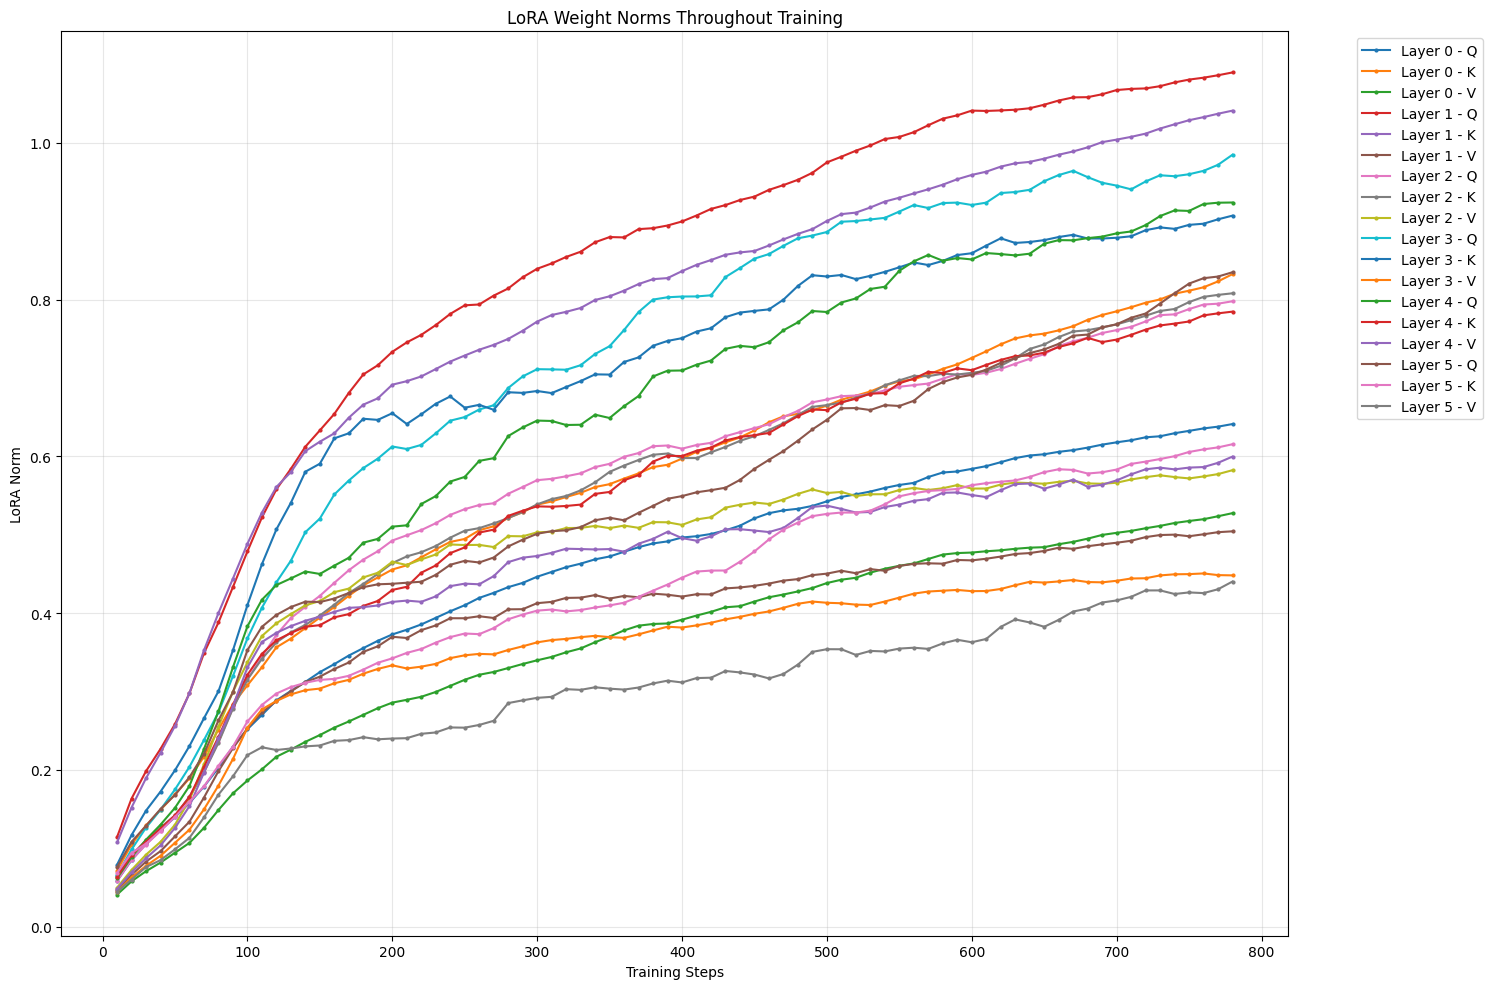

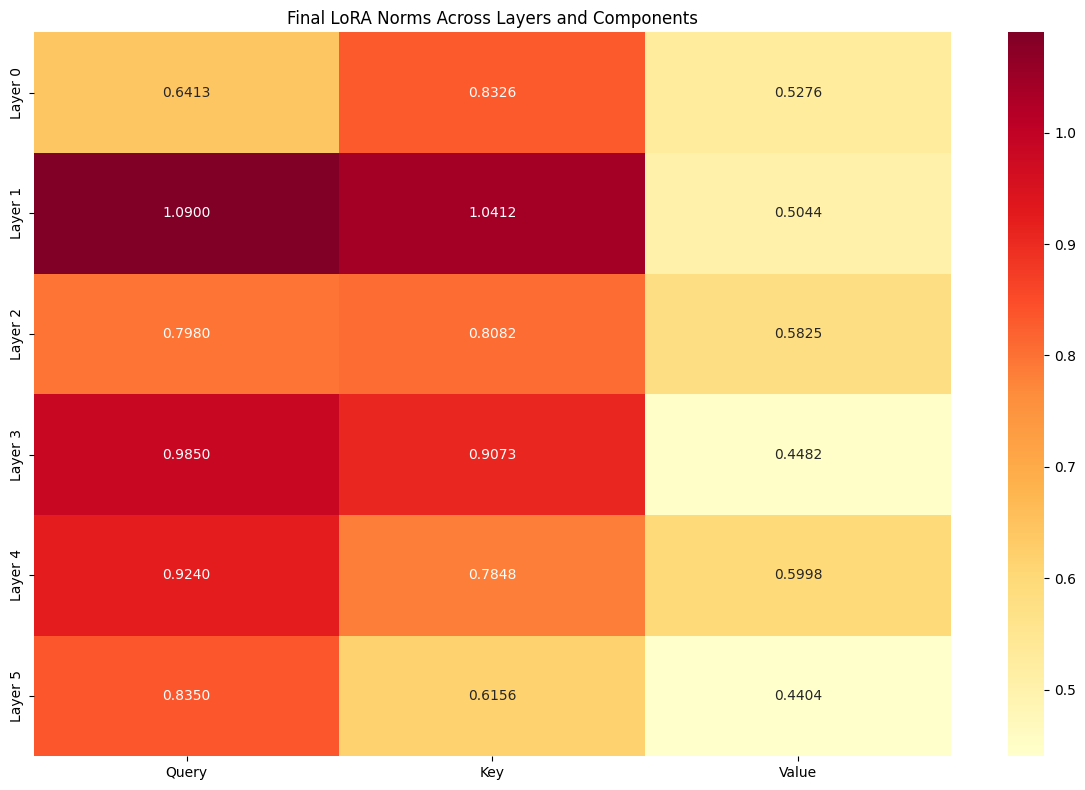


Summary Statistics:

Final LoRA norms for each layer:

Layer 0:
LORA: 0.641337
LORA: 0.832638
LORA: 0.527630

Layer 1:
LORA: 1.089952
LORA: 1.041232
LORA: 0.504440

Layer 2:
LORA: 0.797996
LORA: 0.808161
LORA: 0.582452

Layer 3:
LORA: 0.984985
LORA: 0.907255
LORA: 0.448225

Layer 4:
LORA: 0.923990
LORA: 0.784758
LORA: 0.599816

Layer 5:
LORA: 0.835017
LORA: 0.615589
LORA: 0.440398

Change in LoRA norms (final - initial):
layer_0_q_lora_norm: 0.582930
layer_0_k_lora_norm: 0.761102
layer_0_v_lora_norm: 0.486736
layer_1_q_lora_norm: 0.975607
layer_1_k_lora_norm: 0.933834
layer_1_v_lora_norm: 0.458222
layer_2_q_lora_norm: 0.739836
layer_2_k_lora_norm: 0.743620
layer_2_v_lora_norm: 0.532567
layer_3_q_lora_norm: 0.919556
layer_3_k_lora_norm: 0.828304
layer_3_v_lora_norm: 0.403533
layer_4_q_lora_norm: 0.862310
layer_4_k_lora_norm: 0.721465
layer_4_v_lora_norm: 0.551638
layer_5_q_lora_norm: 0.758991
layer_5_k_lora_norm: 0.546942
layer_5_v_lora_norm: 0.395777


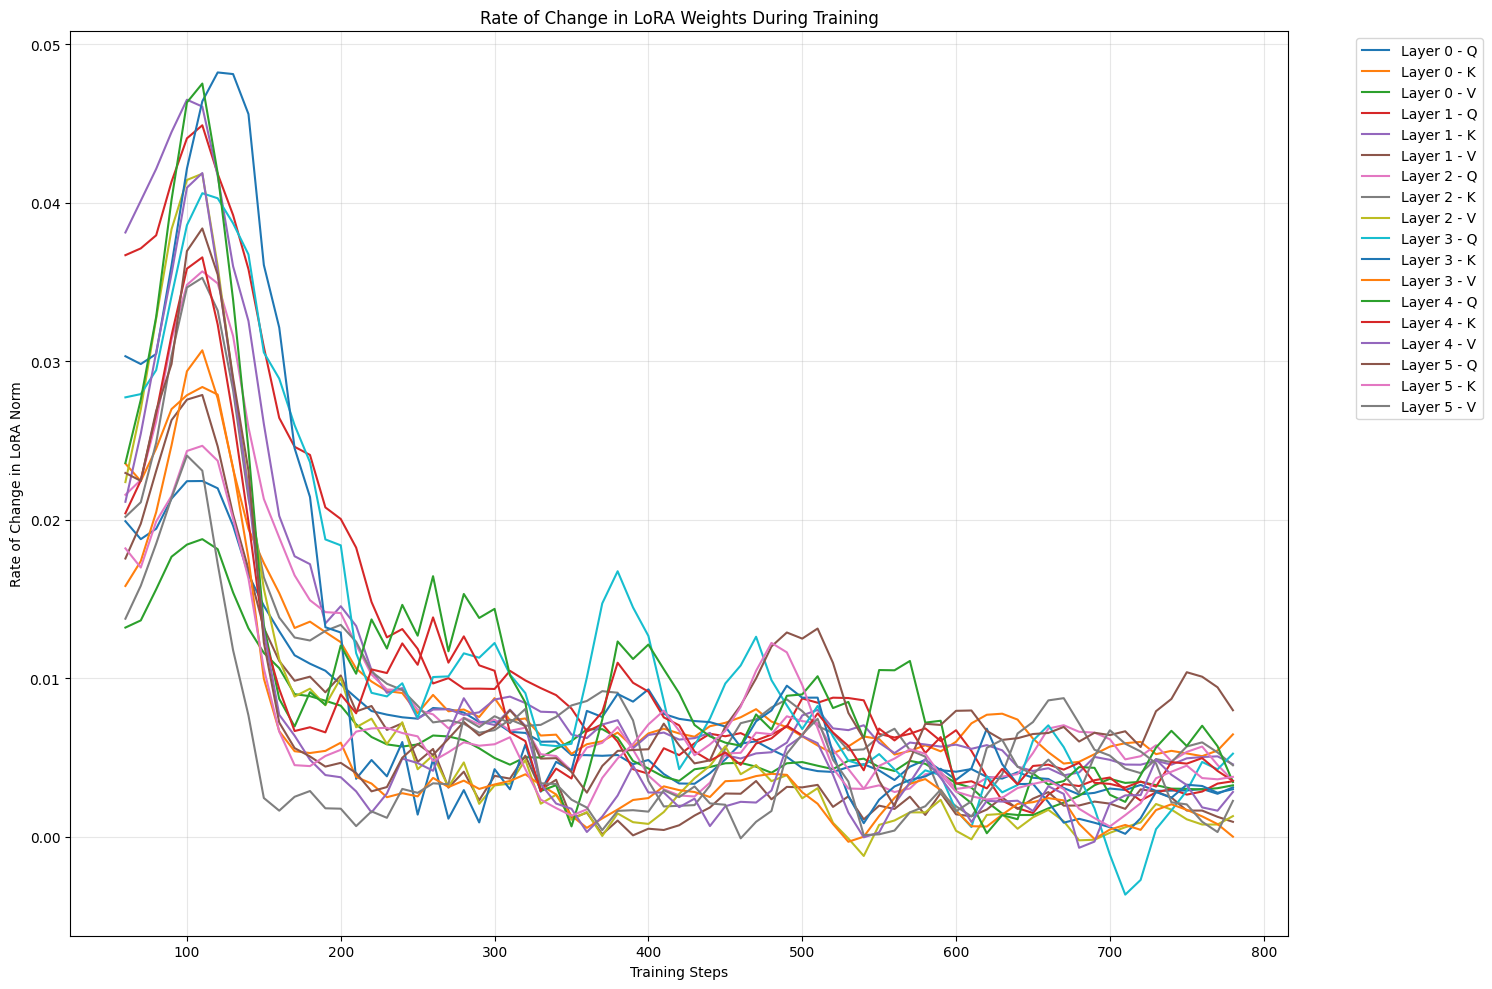

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Convert the history to a DataFrame for easier analysis
def analyze_lora_history(callback_history):
    # Convert history to DataFrame
    df = pd.DataFrame(callback_history)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # Plot LoRA norms over time for each layer and component
    for layer_idx in range(6):
        for component in ['q', 'k', 'v']:
            key = f'layer_{layer_idx}_{component}_lora_norm'
            plt.plot(df['step'], df[key], 
                    label=f'Layer {layer_idx} - {component.upper()}',
                    marker='o', markersize=2)
    
    plt.xlabel('Training Steps')
    plt.ylabel('LoRA Norm')
    plt.title('LoRA Weight Norms Throughout Training')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Heatmap of final LoRA norms
    plt.figure(figsize=(12, 8))
    final_norms = df.iloc[-1].drop('step').values.reshape(6, 3)
    sns.heatmap(final_norms, 
                xticklabels=['Query', 'Key', 'Value'],
                yticklabels=[f'Layer {i}' for i in range(6)],
                annot=True, fmt='.4f',
                cmap='YlOrRd')
    plt.title('Final LoRA Norms Across Layers and Components')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSummary Statistics:")
    print("\nFinal LoRA norms for each layer:")
    for layer_idx in range(6):
        layer_metrics = {k: v for k, v in df.iloc[-1].items() 
                        if f'layer_{layer_idx}' in k}
        print(f"\nLayer {layer_idx}:")
        for k, v in layer_metrics.items():
            print(f"{k.split('_')[-2].upper()}: {v:.6f}")
    
    print("\nChange in LoRA norms (final - initial):")
    for col in df.columns:
        if 'lora_norm' in col:
            change = df[col].iloc[-1] - df[col].iloc[0]
            print(f"{col}: {change:.6f}")
    
    return df

# Use the function with your callback history
df = analyze_lora_history(callback.history)

# Additional analysis: Look at the rate of change
def analyze_rate_of_change(df):
    plt.figure(figsize=(15, 10))
    
    # Calculate rolling average of changes
    window_size = 5  # adjust as needed
    for layer_idx in range(6):
        for component in ['q', 'k', 'v']:
            key = f'layer_{layer_idx}_{component}_lora_norm'
            changes = df[key].diff().rolling(window=window_size).mean()
            plt.plot(df['step'][window_size:], changes[window_size:],
                    label=f'Layer {layer_idx} - {component.upper()}')
    
    plt.xlabel('Training Steps')
    plt.ylabel('Rate of Change in LoRA Norm')
    plt.title('Rate of Change in LoRA Weights During Training')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

analyze_rate_of_change(df)

# Print some key insights
def print_insights(df):
    print("\nKey Insights:")
    
    # Find layers with most change
    final_changes = {}
    for col in df.columns:
        if 'lora_norm' in col:
            change = abs(df[col].iloc[-1] - df[col].iloc[0])
            final_changes[col] = change
    
    most_changed = max(final_changes.items(), key=lambda x: x[1])
    least_changed = min(final_changes.items(), key=lambda x: x[1])
    
    print(f"\nMost changed component: {most_changed[0]} with total change of {most_changed[1]:.6f}")
    print(f"Least changed component: {least_changed[0]} with total change of {least_changed[1]:.6f}")
    
    # Find when most changes occurred
    for layer_idx in range(6):
        layer_cols = [col for col in df.columns if f'layer_{layer_idx}' in col]
        layer_changes = df[layer_cols].diff().abs().mean(axis=1)
        max_change_step = df.iloc[layer_changes.argmax()]['step']
        print(f"\nLayer {layer_idx} had most rapid change around step {max_change_step}")

In [ ]:


print_insights(df)


Key Insights:

Most changed component: layer_1_q_lora_norm with total change of 0.975607
Least changed component: layer_5_v_lora_norm with total change of 0.395777

Layer 0 had most rapid change around step 80.0

Layer 1 had most rapid change around step 70.0

Layer 2 had most rapid change around step 90.0

Layer 3 had most rapid change around step 100.0

Layer 4 had most rapid change around step 100.0

Layer 5 had most rapid change around step 100.0


In [ ]:
slora_log_state = peft_trainer.state.log_history
import pickle
with open('./sst2-result-distilbert-slora-only-mag/wdiff_8_history.pkl', "wb") as f:
    pickle.dump(slora_log_state,f)


In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

def plot_training_metrics(pickle_files, metrics_to_plot, labels=None, figsize=(12, 6)):
    """
    Read multiple pickle files containing training metrics and create comparison plots.
    
    Parameters:
    -----------
    pickle_files : list
        List of paths to pickle files containing training metrics
    metrics_to_plot : list
        List of metric names to plot (e.g., ['loss', 'eval_loss', 'eval_Val-AUC'])
    labels : list, optional
        List of labels for each file in the legend. If None, uses filenames
    figsize : tuple, optional
        Figure size for each plot (width, height)
        
    Returns:
    --------
    dict
        Dictionary containing the figure objects for each metric
    """
    # Load all data
    all_data = {}
    for idx, file_path in enumerate(pickle_files):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            label = labels[idx] if labels else Path(file_path).stem
            all_data[label] = data
            
    # Create a figure for each metric
    figs = {}
    
    for metric in metrics_to_plot:
        plt.figure(figsize=figsize)
        
        for exp_name, data in all_data.items():
            # Extract steps and metric values
            steps = []
            values = []
            
            for entry in data:
                if metric in entry:
                    steps.append(entry.get('step', None))
                    values.append(entry[metric])
            
            if steps and values:
                # Create plot
                sns.set_style("whitegrid")
                plt.plot(steps, values, marker='o', label=exp_name, linewidth=2, markersize=4)
        
        plt.xlabel('Steps')
        plt.ylabel(metric)
        plt.title(f'{metric} Comparison Across Experiments')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        figs[metric] = plt.gcf()
    
    return figs

def plot_training_metrics_grid(pickle_files, metrics_to_plot, labels=None, 
                             n_cols=2, figsize=(15, 10)):
    """
    Create a grid of plots comparing metrics across experiments.
    
    Parameters:
    -----------
    pickle_files : list
        List of paths to pickle files containing training metrics
    metrics_to_plot : list
        List of metric names to plot
    labels : list, optional
        List of labels for each file in the legend
    n_cols : int, optional
        Number of columns in the grid
    figsize : tuple, optional
        Figure size for the entire grid
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing all subplots
    """
    n_metrics = len(metrics_to_plot)
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_metrics > 1 else [axes]
    
    # Load all data
    all_data = {}
    for idx, file_path in enumerate(pickle_files):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            label = labels[idx] if labels else Path(file_path).stem
            all_data[label] = data
    
    # Create plots
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        for exp_name, data in all_data.items():
            steps = []
            values = []
            
            for entry in data:
                if metric in entry:
                    steps.append(entry.get('step', None))
                    values.append(entry[metric])
            
            if steps and values:
                sns.set_style("whitegrid")
                ax.plot(steps, values, marker='o', label=exp_name, linewidth=2, markersize=4)
        
        ax.set_xlabel('Steps')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} Comparison')
        ax.legend()
        ax.grid(True)
    
    # Remove empty subplots if any
    for idx in range(len(metrics_to_plot), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig


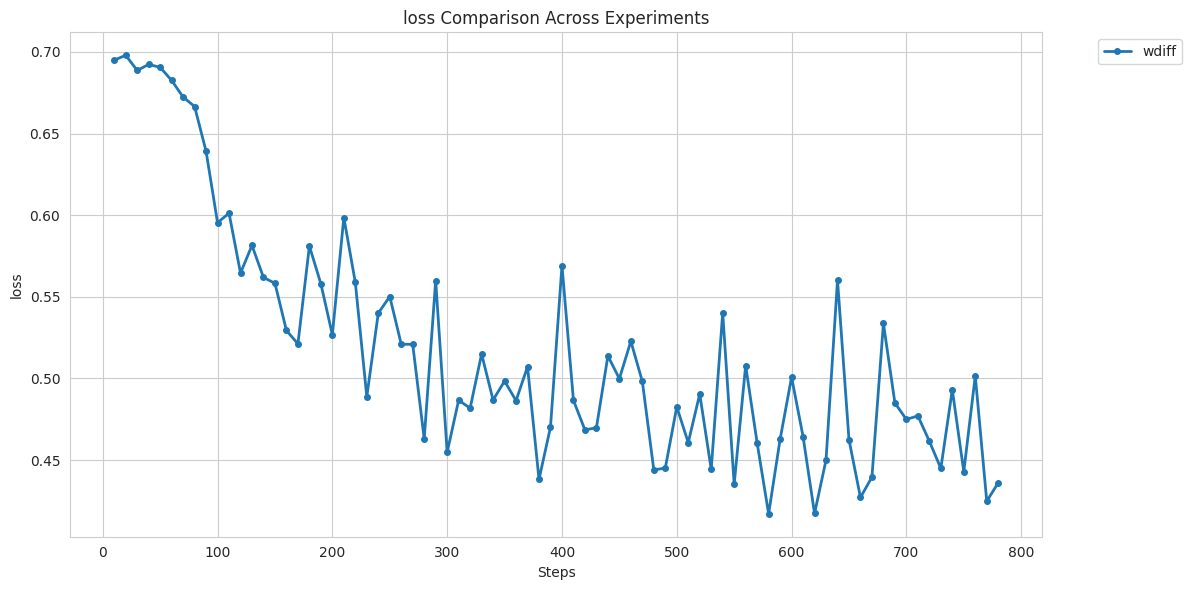

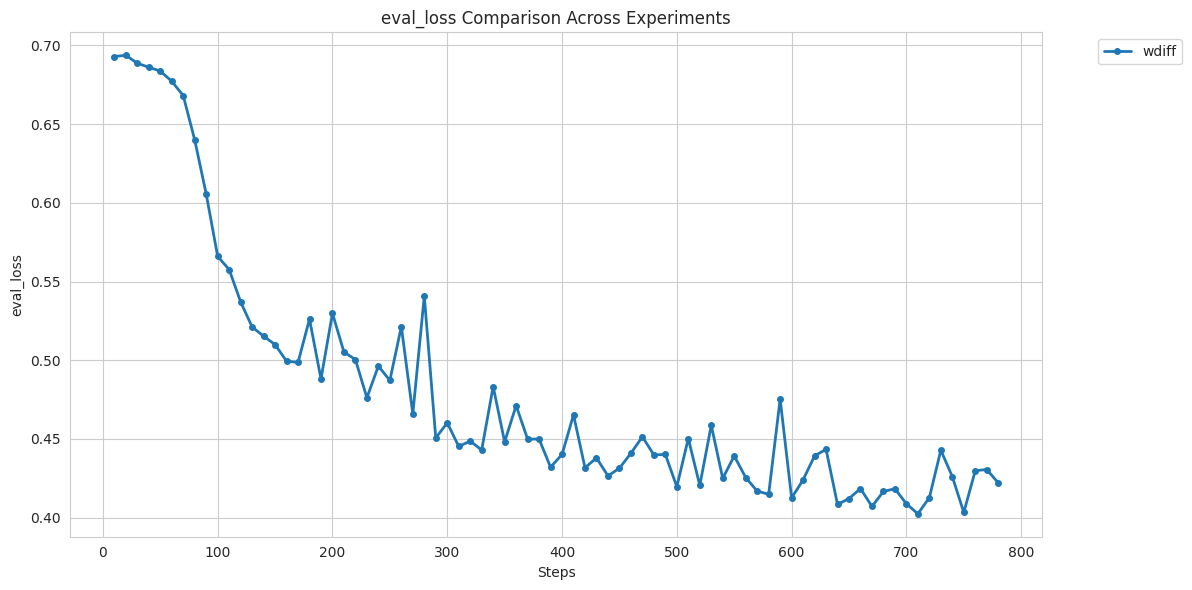

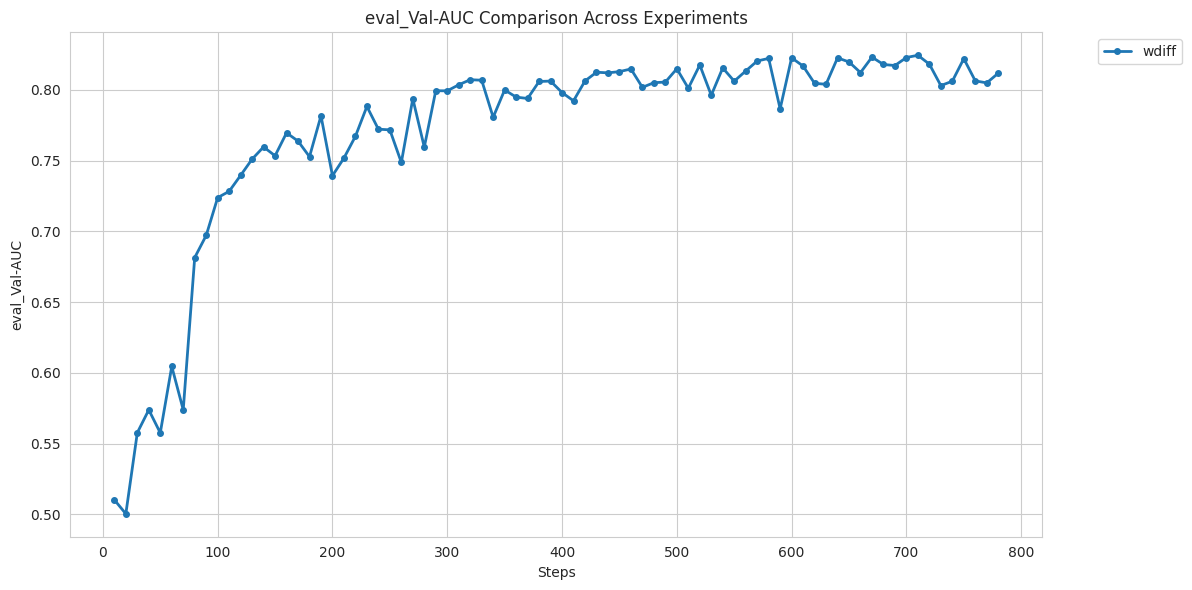

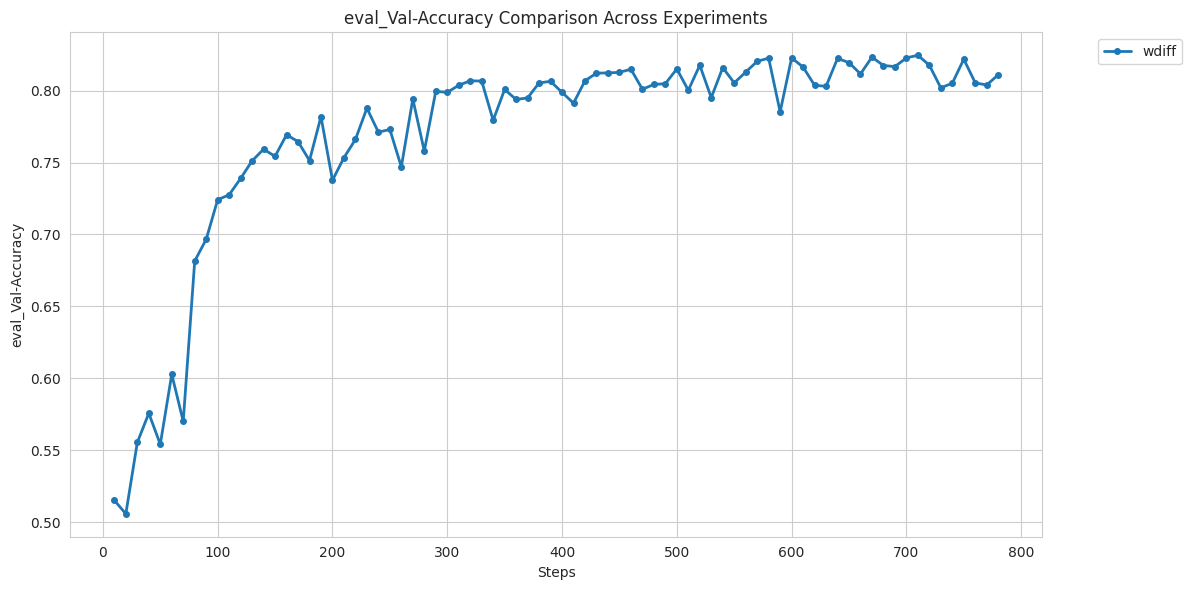

In [ ]:
folder = "./sst2-result-distilbert-slora-only-mag/"
pickle_files = [
    # folder+'slora_8_history.pkl',
    # folder+'lora_8_history.pkl',
    folder+'wdiff_8_history.pkl'
    # folder+'pissa_8_history.pkl',
    # folder+'vera_256_history.pkl',
    # folder+'dora_8_history.pkl',
    ]
metrics = ['loss', 'eval_loss', 'eval_Val-AUC', 'eval_Val-Accuracy']
labels = [
    # 'slora_8', 
    # 'lora_8', 
    'wdiff'
    # "pissa_8", 
    # "vera_256",
    # "dora_8"
    ]

# For separate figures
figures = plot_training_metrics(pickle_files, metrics, labels)

# For grid layout
# fig = plot_training_metrics_grid(pickle_files, metrics, labels)
plt.show()

In [ ]:
import torch

def extract_and_analyze_diagonal(matrix):
    """
    Extracts diagonal from a matrix and computes its magnitude and direction.
    
    Args:
        matrix (torch.Tensor): Square matrix with diagonal elements
        
    Returns:
        tuple: (diagonal vector, magnitude, direction unit vector)
    """
    # Extract diagonal using torch.diag
    diagonal = torch.diag(matrix)
    
    # Compute magnitude (length) of the diagonal vector
    magnitude = torch.norm(diagonal)
    
    # Compute direction (unit vector)
    # Add small epsilon to avoid division by zero
    direction = diagonal / (magnitude + 1e-8)
    
    return diagonal, magnitude, direction

# Example usage
def demo_diagonal_analysis():
    # Create a sample diagonal matrix
    diagonal_matrix = torch.tensor([
        [2., 0., 0.],
        [0., -3., 0.],
        [0., 0., 4.]
    ])
    
    diagonal, magnitude, direction = extract_and_analyze_diagonal(diagonal_matrix)
    
    print(f"Diagonal vector: {diagonal}")
    print(f"Magnitude: {magnitude:.4f}")
    print(f"Direction unit vector: {direction}")
    
    # Verify that direction is unit vector (magnitude ≈ 1)
    print(magnitude*direction)
    print(f"Direction magnitude (should be ≈ 1): {torch.norm(direction):.4f}")

demo_diagonal_analysis()

Diagonal vector: tensor([ 2., -3.,  4.])
Magnitude: 5.3852
Direction unit vector: tensor([ 0.3714, -0.5571,  0.7428])
tensor([ 2.0000, -3.0000,  4.0000])
Direction magnitude (should be ≈ 1): 1.0000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SLayer(nn.Module):
    def __init__(self, diagonal_matrix, learn_direction=True, learn_magnitude=True):
        """
        Initialize layer from an existing diagonal matrix's diagonal values.
        
        Args:
            diagonal_matrix (torch.Tensor): Input diagonal matrix to initialize from
            learn_direction (bool): Whether to learn the direction of the diagonal vector
            learn_magnitude (bool): Whether to learn the magnitude scaling
        """
        super().__init__()
        
        # Extract the diagonal values
        init_diagonal = torch.diag(diagonal_matrix)
        init_magnitude = torch.norm(init_diagonal)
        init_direction = init_diagonal / init_magnitude
        
        # Initialize parameters based on learning configuration
        if learn_direction:
            self.direction = nn.Parameter(init_direction)
        else:
            self.register_buffer('direction', init_direction)
            
        if learn_magnitude:
            self.magnitude = nn.Parameter(torch.tensor([init_magnitude]))
        else:
            self.register_buffer('magnitude', torch.tensor([init_magnitude]))
    
    def forward(self, x):
        """
        Forward pass: converts diagonal vector to matrix and applies transformation.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n)
            
        Returns:
            torch.Tensor: Transformed input using diagonal matrix
        """
        # Normalize direction and scale by magnitude
        normalized_direction = F.normalize(self.direction, dim=0)
        diagonal = normalized_direction * self.magnitude
        
        # Create diagonal matrix for transformation
        diag_matrix = torch.diag(diagonal)
        
        return torch.matmul(x, diag_matrix)
    
    @property
    def diagonal_matrix(self):
        """
        Property to get current diagonal matrix.
        """
        normalized_direction = F.normalize(self.direction, dim=0)
        diagonal = normalized_direction * self.magnitude
        return torch.diag(diagonal)
    
    @property
    def diagonal_vector(self):
        """
        Property to get current diagonal vector.
        """
        normalized_direction = F.normalize(self.direction, dim=0)
        return normalized_direction * self.magnitude

# Example usage
def demo_transform_layer():
    # Create a sample diagonal matrix
    original_matrix = torch.diag(torch.tensor([2., -3., 4.]))
    
    # Create layers with different learning configurations
    layer_full = DiagonalTransformLayer(original_matrix, learn_direction=True, learn_magnitude=True)
    layer_direction = DiagonalTransformLayer(original_matrix, learn_direction=True, learn_magnitude=False)
    layer_magnitude = DiagonalTransformLayer(original_matrix, learn_direction=False, learn_magnitude=True)
    
    print("Original diagonal:", torch.diag(original_matrix))
    print("\nInitialized diagonal vectors:")
    print("Full learning:", layer_full.diagonal_vector)
    print("Direction only:", layer_direction.diagonal_vector)
    print("Magnitude only:", layer_magnitude.diagonal_vector)
    
    # Test forward pass
    x = torch.randn(2, 3)  # batch_size=2, size=3
    out1 = layer_full(x)
    out2 = layer_direction(x)
    out3 = layer_magnitude(x)
    print("\nForward pass output shape:", out1.shape)
    print(out1, out2, out3)

In [ ]:
demo_transform_layer()

NameError: name 'DiagonalTransformLayer' is not defined

In [ ]:
a = torch.rand(4,4)
a.mannaia = 2

In [ ]:
import numpy as np

# Create a sample 2x2 matrix
M = np.array([[2, 1],
              [1, 3]])

# Create a vector
v = np.array([3, 4])

# Calculate magnitude (length) of vector
magnitude = np.linalg.norm(v)  # sqrt(3² + 4²) = 5

# Calculate direction (unit vector)
direction = v / magnitude  # [3/5, 4/5]

print(f"Original vector v: {v}")
print(f"Magnitude: {magnitude}")
print(f"Direction (unit vector): {direction}")

# Method 1: Direct multiplication (M * v)
result1 = M @ v

# Method 2: Using magnitude and direction (M * magnitude * direction)
result2 = M @ (magnitude * direction)

print("\nResult of M * v:")
print(result1)
print("\nResult of M * magnitude * direction:")
print(result2)

# Verify they're equal
print("\nAre results equal?", np.allclose(result1, result2))

In [ ]:
import numpy as np

# Example setup
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[1, 2],
               [2, 1]])

# Two diagonal matrices represented by vectors
v1 = np.array([3, 4])
v2 = np.array([6, 8])  # Different magnitude, same direction

# Extract magnitudes
mag1 = np.linalg.norm(v1)  # 5
mag2 = np.linalg.norm(v2)  # 10

# The direction is the same for both
direction = v1 / mag1  # or v2/mag2, they're the same

# Smart average calculation
M_avg = 0.5 * (M1 + M2)
mag_avg = 0.5 * (mag1 + mag2)  # Average the magnitudes

# Final result using averaged magnitude and constant direction
result = mag_avg * (M_avg @ np.diag(direction))

print("Average magnitude:", mag_avg)
print("Constant direction:", direction)
print("\nFinal result:")
print(result)

In [ ]:
import numpy as np

# Example setup
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[1, 2],
               [2, 1]])

# Vectors representing diagonal matrices
v1 = np.array([3, 4])
v2 = np.array([6, 8])  # Different magnitude, same direction

# Number of samples/weights for each client (example)
n1 = 100  # samples from client 1
n2 = 200  # samples from client 2
total_samples = n1 + n2

# Federated averaging weights
w1 = n1/total_samples
w2 = n2/total_samples

# 1. Average M using FedAvg weights
M_fedavg = w1 * M1 + w2 * M2

# 2. Average D (through vectors)
# Since direction is constant, we only need to fedavg the magnitudes
mag1 = np.linalg.norm(v1)
mag2 = np.linalg.norm(v2)
direction = v1 / mag1  # constant direction

# Federated average of magnitudes
mag_fedavg = w1 * mag1 + w2 * mag2

# The averaged D can be reconstructed as:
D_fedavg = np.diag(mag_fedavg * direction)

# 3. To get back magnitude from averaged D:
mag_from_D = np.linalg.norm(np.diag(D_fedavg))  # should equal mag_fedavg

print("FedAvg magnitude:", mag_fedavg)
print("Magnitude from averaged D:", mag_from_D)
print("\nAveraged direction (should be constant):", direction)
print("\nFedAvg Matrix M:")
print(M_fedavg)
print("\nFedAvg Diagonal Matrix D:")
print(D_fedavg)

In [ ]:
s_diag = torch.diag(torch.rand(3,3))
a = torch.rand(4,3)
b = torch.rand(4,3)

In [ ]:
s_mag = torch.linalg.norm(s_diag)
b_s_mag = s_mag + 0.3
s_dir = s_diag/s_mag
b_s_dir = s_diag/b_s_mag
s_diag,s_mag,s_dir,b_s_mag,b_s_dir

In [ ]:
a@torch.diag(s_diag)

In [ ]:
torch.linalg.norm(s_diag),s_mag

In [ ]:
a *s_mag @ torch.diag(s_dir)

In [ ]:
a *s_mag @ torch.diag(s_dir)

In [ ]:
1/2 * (a*s_mag + b*b_s_mag)

In [ ]:
((a + b)/2 * (s_mag * b_s_mag)/2) *2

In [ ]:
import numpy as np

# Original matrix
M = np.array([[2, 1],
              [1, 3]])

# 1. Separate into magnitude and direction
magnitude = np.linalg.norm(M, 'fro')  # Frobenius norm
direction = M / magnitude  # Normalized matrix

print("Original matrix:")
print(M)
print("\nMagnitude:", magnitude)
print("\nDirection (normalized matrix):")
print(direction)

# 2. Verify we can reconstruct
reconstructed = magnitude * direction
print("\nReconstructed matrix:")
print(reconstructed)
print("\nAre they equal?", np.allclose(M, reconstructed))

# 3. This means when averaging matrices, you could:
M1 = np.array([[2, 1],
               [1, 3]])
M2 = np.array([[4, 2],
               [2, 6]])  # M1 scaled by 2

mag1 = np.linalg.norm(M1, 'fro')
mag2 = np.linalg.norm(M2, 'fro')
dir1 = M1 / mag1
dir2 = M2 / mag2

# If matrices only differ by scale:
print("\nDirections equal?", np.allclose(dir1, dir2))

In [ ]:
torch.linalg.norm((a*s_mag+b*b_s_mag)/2)

In [ ]:
(s_mag+b_s_mag)/2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NormOnlyLinear(nn.Module):
   def __init__(self, in_features, out_features, norm_type='fro'):
       super().__init__()
       self.norm_type = norm_type
       
   def set_weight_norm(initial_weight=None):
       # Use provided weights or create random ones
       if initial_weight is not None:
           assert initial_weight.shape == (out_features, in_features), \
               f"Weight shape mismatch. Expected {(out_features, in_features)}, got {initial_weight.shape}"
           temp_weight = initial_weight
       else:
           temp_weight = torch.randn(out_features, in_features)
           
       with torch.no_grad():
           # Extract norm and direction
           norm = torch.norm(temp_weight, p=norm_type)
           self.weight_direction = temp_weight / norm
           
       # Only norm is trainable
       self.weight_norm = nn.Parameter(torch.Tensor([norm]))
    #    self.bias = nn.Parameter(torch.zeros(out_features))
       
   def forward(self, x):
       # Reconstruct weight matrix
       weight = self.weight_direction * self.weight_norm
       return F.linear(x, weight,)
   
   @property
   def weight(self):
       """Get current weight matrix"""
       return self.weight_direction * self.weight_norm
   
   def extra_repr(self):
       return (f'in_features={self.weight_direction.size(1)}, '
               f'out_features={self.weight_direction.size(0)}, '
               f'norm_type={self.norm_type}')


# Example usage:
if __name__ == "__main__":
   # Create some initial weights
   init_weight = torch.tensor([[1., 2., 3.],
                             [4., 5., 6.]])
   
   # Create layer with custom weights
   layer = NormOnlyLinear(3, 2, initial_weight=init_weight, norm_type='fro')
   
   # Create layer with random weights
   layer_random = NormOnlyLinear(3, 2, norm_type=2)  # Using spectral norm
   
   # Test both layers
   x = torch.randn(4, 3)  # batch_size=4, in_features=3
   
   print("Layer with custom weights:")
   print("Initial weight norm:", layer.weight_norm.item())
   print("Output shape:", layer(x).shape)
   
   print("\nLayer with random weights:")
   print("Initial weight norm:", layer_random.weight_norm.item())
   print("Output shape:", layer_random(x).shape)
   
   # Verify only norm is trainable
   print("\nTrainable parameters in custom weight layer:")
   for name, param in layer.named_parameters():
       print(f"{name}: requires_grad = {param.requires_grad}")
   
   # Example of different norm types
   norms = ['fro', 2, 1, float('inf')]
   for norm_type in norms:
       layer = NormOnlyLinear(3, 2, initial_weight=init_weight, norm_type=norm_type)
       print(f"\nNorm type {norm_type}:")
       print("Initial norm:", layer.weight_norm.item())
   print(layer.weight_direction)

In [ ]:
torch.zeros(torch.rand(4,5).shape)

In [ ]:
import torch
a = torch.rand(3,3)
b = torch.rand(3,3)
s1 = torch.diag(torch.rand(3,3))

In [ ]:
mag_s1 = torch.linalg.norm(s1)
mag_s2 = mag_s1 + 0.3
direction = s1/mag_s1
print(mag_s1,mag_s2,direction)

In [ ]:
(a*mag_s1 + b*mag_s2)/2

In [ ]:
((a+b)/2 @ (mag_s1 * torch.eye(3) + mag_s2 *torch.eye(3))/2) - (a*mag_s1 + b*mag_s2)/2

In [ ]:
import torch

b1 = torch.rand(4,5)
b2 = torch.rand(4,5)
m1 = torch.rand(1)
m2 = torch.rand(1)

In [ ]:
torch.diag(torch.tensor([5.3542, 4.5933, 4.2581, 4.2319, 3.9345, 3.8549, 3.7414, 3.7272]))

In [ ]:
b = torch.rand(4,5)

In [ ]:
res = b@b.T - torch.eye(4)

In [ ]:
b@b.T - res

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [ ]:
import os

with open('./peft/full_req.txt') as f: 
    print(f.read())